In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#packages for data preprocessing
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks, ClusterCentroids
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

#packages for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline as imbpipeline, make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report, confusion_matrix, auc
import gc

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

## Load data

In [ ]:
train_month_3 = pd.read_csv('./train_month_3_with_target.csv')
test_month_3 = pd.read_csv('./test_month_3.csv')
train_month_2 = pd.read_csv('./train_month_2.csv')
train_month_1 = pd.read_csv('./train_month_1.csv')
test_month_2 = pd.read_csv('./test_month_2.csv')
test_month_1 = pd.read_csv('./test_month_1.csv')


In [ ]:
#combine three datasets for train and test dataset respectively

lst= ['client_id','customer_gender','customer_birth_date','customer_since_bank','customer_since_all']
train_month_1 = train_month_1.drop(lst,axis=1)
for col in train_month_1:
    train_month_3[col+'-tt-2']=train_month_1[col]
    
test_month_1 = test_month_1.drop(lst,axis=1)
for col in test_month_1:
    test_month_3[col+'-tt-2']=test_month_1[col]
    
train_month_2 = train_month_2.drop(lst,axis=1)
for col in train_month_2:
    train_month_3[col+'-tt-1']=train_month_2[col]
    
test_month_2 = test_month_2.drop(lst,axis=1)
for col in test_month_2:
    test_month_3[col+'-tt-1']=test_month_2[col]
    
train = train_month_3
test = test_month_3
print(train.shape)
print(test.shape)

(63697, 108)
(27300, 107)


In [ ]:
#turn date type column into years count
import datetime as dt
now = pd.Timestamp('now')
train_month_3['customer_since_all'] = pd.to_datetime(train_month_3.customer_since_all)
train_month_3.customer_since_all = (now - train_month_3.customer_since_all).astype('<m8[Y]')
train_month_3['customer_since_bank'] = pd.to_datetime(train_month_3.customer_since_bank)
train_month_3['customer_since_bank'] = (now - train_month_3.customer_since_bank).astype('<m8[Y]')
train_month_3['customer_birth_date'] = pd.to_datetime(train_month_3.customer_birth_date)
train_month_3['customer_birth_date'] = (now - train_month_3.customer_birth_date).astype('<m8[Y]')

test_month_3['customer_since_all'] = pd.to_datetime(test_month_3.customer_since_all)
test_month_3['customer_since_all'] = (now - test_month_3.customer_since_all).astype('<m8[Y]')
test_month_3['customer_since_bank'] = pd.to_datetime(test_month_3.customer_since_bank)
test_month_3['customer_since_bank'] = (now - test_month_3.customer_since_bank).astype('<m8[Y]')
test_month_3['customer_birth_date'] = pd.to_datetime(test_month_3.customer_birth_date)
test_month_3['customer_birth_date'] = (now - test_month_3.customer_birth_date).astype('<m8[Y]')


In [ ]:
print(train_month_3.target[train_month_3['target'] == 1].count())
print(train_month_3.target[train_month_3['target'] == 0].count())

1913
61784


## Data Splitting and Preprocessing

In [ ]:
#spliting data
#drop the column with missing value percentage over 50%
train_month_3 = train_month_3.drop(['client_id', 'customer_education'], axis=1)
x = train_month_3.drop('target', axis=1)
target = train_month_3['target']

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, target, test_size=0.2, random_state=42, stratify=target)

In [ ]:
test = test_month_3.drop(['client_id','customer_education'], axis=1) 

#get dummies on train and test datasets
x_train = pd.get_dummies(x_train)
x_val = pd.get_dummies(x_val)
test = pd.get_dummies(test)

imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
x_train = imputer.fit_transform(x_train)
x_val = imputer.transform(x_val)

print(x_train.shape)
print(x_val.shape)

(50957, 129)
(12740, 129)


In [ ]:
resample = SMOTETomek(random_state=42)
x_train, y_train = resample.fit_resample(x_train, y_train)

## Four Models with default parameters

The below four models all follow such data preprocessing:
+ Categorical Variable Encoding: One-Hot-Encoding
+ Missing value: KNNImputer
+ Class Imbalance: SMOTE (oversampling)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
y_pred = dt.predict(x_val)
dt_auc = roc_auc_score(y_val, dt.predict_proba(x_val)[:, 1])
#print(dt_auc)

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)
rf_auc = roc_auc_score(y_val, rf.predict_proba(x_val)[:,1])
#print(rf_auc)

In [ ]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train, y_train)
lr_auc = roc_auc_score(y_val, lr.predict_proba(x_val)[:,1])
#print(lr_auc)

In [ ]:
lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(x_train, y_train)
lgbm_auc = roc_auc_score(y_val, lgbm.predict_proba(x_val)[:,1])
#print(lgbm_auc)

In [ ]:
table = pd.DataFrame(data={
'Model': ['Decision Trees', 'Random Forest', 'Logistic Regression', 'LightGBM'],
'AUC Score': [dt_auc, rf_auc, lr_auc, lgbm_auc]})
print(table)

                 Model  AUC Score
0       Decision Trees   0.521371
1        Random Forest   0.671936
2  Logistic Regression   0.688043
3             LightGBM   0.711337


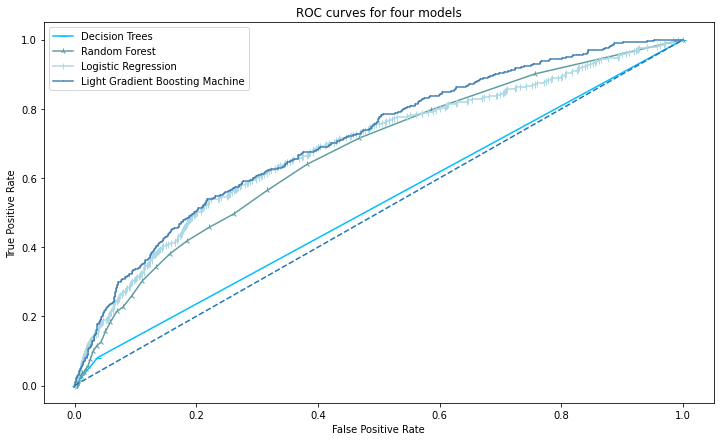

In [ ]:
from sklearn.metrics import roc_curve
ns_probs = [0 for _ in range(len(x_val))]

# keep probabilities for the positive outcome only

# calculate scores then print them
ns_auc = roc_auc_score(y_val, ns_probs)

# calculate roc curves
dt_fpr, dt_tpr, _ = roc_curve(y_val,dt.predict_proba(x_val)[:,1] )
rf_fpr, rf_tpr, _ = roc_curve(y_val, rf.predict_proba(x_val)[:,1] )
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr.predict_proba(x_val)[:,1] )
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_val, lgbm.predict_proba(x_val)[:,1])
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
# plot the roc curve for the model
plt.figure(figsize = (12,7),facecolor='white')
plt.ylabel('True Positive Rate')

plt.plot(dt_fpr, dt_tpr, marker='_', label='Decision Trees', color='deepskyblue')
plt.plot(rf_fpr, rf_tpr, marker='2', label='Random Forest', color='cadetblue')
plt.plot(lr_fpr, lr_tpr, marker='|', label='Logistic Regression', color='lightblue')
plt.plot(lgbm_fpr, lgbm_tpr, marker=',', label='Light Gradient Boosting Machine', color='steelblue')
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.legend()
plt.title('ROC curves for four models')
plt.xlabel('False Positive Rate')

plt.savefig('ROC curves for four models.png',)

## model--lightgbm
### Resampling strategies used during cross validation with lightgbm

1. oversampling: SMOTE
2. undersampling: Tomek, ClusterCentroid
3. combined: SMOTETomek
4. lgbmClassifier: class_weight='balanced'

auc performance rank: 4>3>1>2

### Missing value imputer

1. KNNImputer
2. SimpleImputer
3. lgbmClassifier

auc performance 3>1>2

### Parameter Tuning



In [ ]:
train_month_3 = pd.read_csv('/Users/yilia/Downloads/KUL/SDS_Courses/Advanced Analytics in a big data world/assignments/data/train_month_3_with_target.csv')
test_month_3 = pd.read_csv('/Users/yilia/Downloads/KUL/SDS_Courses/Advanced Analytics in a big data world/assignments/data/test_month_3.csv')
train_month_2 = pd.read_csv('/Users/yilia/Downloads/KUL/SDS_Courses/Advanced Analytics in a big data world/assignments/data/train_month_2.csv')
train_month_1 = pd.read_csv('/Users/yilia/Downloads/KUL/SDS_Courses/Advanced Analytics in a big data world/assignments/data/train_month_1.csv')
test_month_2 = pd.read_csv('/Users/yilia/Downloads/KUL/SDS_Courses/Advanced Analytics in a big data world/assignments/data/test_month_2.csv')
test_month_1 = pd.read_csv('/Users/yilia/Downloads/KUL/SDS_Courses/Advanced Analytics in a big data world/assignments/data/test_month_1.csv')


In [ ]:
#combine three datasets for train and test dataset respectively

lst= ['client_id','customer_gender','customer_birth_date','customer_since_bank','customer_since_all']
train_month_1 = train_month_1.drop(lst,axis=1)
for col in train_month_1:
    train_month_3[col+'-tt-2']=train_month_1[col]
    
test_month_1 = test_month_1.drop(lst,axis=1)
for col in test_month_1:
    test_month_3[col+'-tt-2']=test_month_1[col]
    
train_month_2 = train_month_2.drop(lst,axis=1)
for col in train_month_2:
    train_month_3[col+'-tt-1']=train_month_2[col]
    
test_month_2 = test_month_2.drop(lst,axis=1)
for col in test_month_2:
    test_month_3[col+'-tt-1']=test_month_2[col]

In [ ]:
#turn date type column into years count
import datetime as dt
now = pd.Timestamp('now')
train_month_3['customer_since_all'] = pd.to_datetime(train_month_3.customer_since_all)
train_month_3.customer_since_all = (now - train_month_3.customer_since_all).astype('<m8[Y]')
train_month_3['customer_since_bank'] = pd.to_datetime(train_month_3.customer_since_bank)
train_month_3['customer_since_bank'] = (now - train_month_3.customer_since_bank).astype('<m8[Y]')
train_month_3['customer_birth_date'] = pd.to_datetime(train_month_3.customer_birth_date)
train_month_3['customer_birth_date'] = (now - train_month_3.customer_birth_date).astype('<m8[Y]')

test_month_3['customer_since_all'] = pd.to_datetime(test_month_3.customer_since_all)
test_month_3['customer_since_all'] = (now - test_month_3.customer_since_all).astype('<m8[Y]')
test_month_3['customer_since_bank'] = pd.to_datetime(test_month_3.customer_since_bank)
test_month_3['customer_since_bank'] = (now - test_month_3.customer_since_bank).astype('<m8[Y]')
test_month_3['customer_birth_date'] = pd.to_datetime(test_month_3.customer_birth_date)
test_month_3['customer_birth_date'] = (now - test_month_3.customer_birth_date).astype('<m8[Y]')


In [ ]:
from bayes_opt import BayesianOptimization, UtilityFunction
# Define the black box function to optimize.
def bayes_parameter_opt_lgb(x_train, y_train, init_round=20, opt_round=25, 
                            n_folds=5, random_seed=42, n_estimators=10000, output_process=False):
    train_data = lgb.Dataset(data=x_train, label=y_train)
    def lgb_eval(num_leaves, feature_fraction,learning_rate, bagging_fraction, reg_lambda, reg_alpha):
        params = {'objective':'binary','num_iterations':10000, 'class_weigth':'balanced', 'early_stopping_round':200, 'metric':'auc'}
        params["num_leaves"] = round(num_leaves)
        params['learning_rate'] = max(learning_rate, 0)
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['reg_lambda'] = max(reg_lambda, 0)
        params['reg_alpha'] = max(reg_alpha, 0)
                  
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                            'learning_rate': (0.01, 1),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'reg_alpha': (0.1, 4),
                                        'reg_lambda': (0.1, 3)},
                                        random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # return best parameters
    return max(lgbBO.res, key=lambda x:x['target'])['params']

opt_params = bayes_parameter_opt_lgb(x_train, y_train, init_round=20, opt_round=25, n_folds=5, random_seed=42, n_estimators=10000)
print(opt_params_params)

In [ ]:
#classifier model: light gradient boosting (lgbmClassifier) together with kfold cross validation
def model(features_train, features_test, encoding = 'ohe', n_folds=5):
    train_ids = features_train['client_id']
    test_ids = features_test['client_id']
    targets = features_train['target']
    features_train =features_train.drop(['target','customer_education'], axis=1)
    #features_train = features_train.drop(lst, axis=1)
    #features_test = features_test.drop(lst, axis=1)
    features_test = features_test.drop('customer_education', axis=1)
    #One Hot Encoding
    features_train = pd.get_dummies(features_train)
    features_test = pd.get_dummies(features_test)
   #align the dataframes by the columns
    features_train, features_test = features_train.align(features_test, join='inner', axis=1)
    cat_indices = 'auto'
        
    print('training data shape:', features_train.shape)
    print('testing data shape:', features_test.shape)
    
    feature_names = list(features_train.columns)
    features_train = np.array(features_train)
    features_test = np.array(features_test)
    feature_importance_values = np.zeros(len(feature_names))
    test_predictions = np.zeros(features_test.shape[0])
    out_of_fold = np.zeros(features_train.shape[0])
    valid_scores = []
    train_scores = []
    targets_actu = []
    targets_pred = []

    #create the stratified kfold object to maintain same class distribution
    stratified_kfold = StratifiedKFold(n_splits = n_folds, shuffle=True, random_state=42)
    
    #iterate through each fold
    for train_indices, valid_indices in stratified_kfold.split(features_train, targets):
        tr_features, tr_targets = features_train[train_indices], targets[train_indices]
        val_features, val_targets = features_train[valid_indices], targets[valid_indices
        
        """#extra data preprocessing steps can be added here:
        imputer = KNNImputer(n_neighbors=5, weights='uniform')
        tr_features = imputer.fit_transform(tr_features)
        val_featuress= imputer.transform(val_features)
        #resample = SMOTETomek()
        #tr_features, tr_targets = resample.fit_resample(tr_features, tr_targets)
       """
        model = lgb.LGBMClassifier(n_estimators=10000, objective='binary',
                                   class_weight='balanced',
                                   learning_rate=0.01,
                                   reg_alpha=3.78,
                                   reg_lambda=1.61,
                                   feature_fraction=0.61,
                                   bagging_fraction=0.82,
                                   num_leaves=27,
                                   subsample=0.99,
                                   n_jobs=-1,
                                   random_state=42)
        
        #train the model
        model.fit(tr_features, tr_targets, eval_metric='auc', 
                  eval_set=[(val_features, val_targets), (tr_features, tr_targets)],
                  eval_names=['valid', 'train'],categorical_feature = cat_indices, early_stopping_rounds=200, verbose=200)
        
        #record the best iteration
        best_iteration = model.best_iteration_
        #record the feature importance
        feature_importance_values += model.feature_importances_ / stratified_kfold.n_splits
        #make predictions
        test_predictions += model.predict_proba(features_test, num_interation =best_iteration)[:,1] / stratified_kfold.n_splits
        #record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(val_features, num_iteration=best_iteration)[:,1]
        
        #record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        pred= model.predict(val_features)
        targets_actu.extend(val_targets)
        targets_pred.extend(pred)
        
        #clean up memory
        gc.enable()
        del model, tr_features, val_features
        gc.collect()
      
    #make submission dataframe
    submission = pd.DataFrame({'ID': test_ids, 'PROB':test_predictions})
    
    #make feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    #overall validation score
    valid_auc = roc_auc_score(targets, out_of_fold)
    precision, recall, thresholds = precision_recall_curve(targets, out_of_fold)
    
    #add the average scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    #needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('average')
    
    #dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})
    

    
    return submission, feature_importances, metrics, targets_pred, targets_actu, out_of_fold#, predicted_classes, predicted_proba


In [ ]:
submission, fi, metrics, targets_pred, targets_actu, out_of_fold= model(train_month_3, test_month_3)
print('AUC metrics')
print(metrics)

In [ ]:
classification_report = classification_report(targets_actu, targets_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.98      0.74      0.85     61784
           1       0.07      0.61      0.12      1913

    accuracy                           0.74     63697
   macro avg       0.53      0.67      0.48     63697
weighted avg       0.96      0.74      0.82     63697



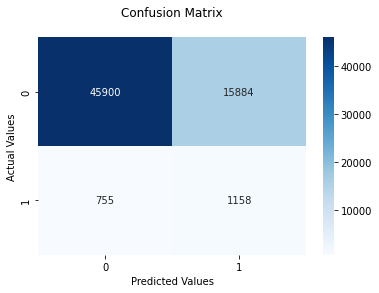

In [ ]:
cm = confusion_matrix(targets_actu, targets_pred)
fig = sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
fig.set_title('Confusion Matrix\n')
fig.set_xlabel('Predicted Values')
fig.set_ylabel('Actual Values')
plt.savefig('confusion matrix.png')
plt.show()


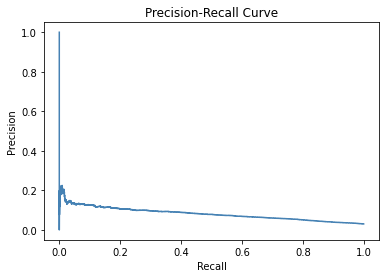

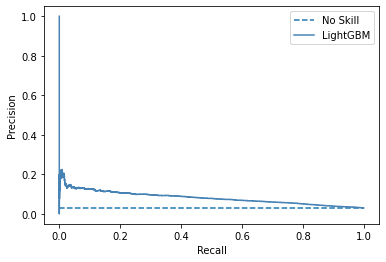

In [ ]:
#Precision Recall Curve Plot
from sklearn.metrics import precision_recall_curve
targets = train_month_3['target']
precision, recall, thresholds = precision_recall_curve(targets, out_of_fold)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='steelblue')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

def plot_pr_curve(test_y, model_probs):
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(test_y[test_y==1]) / len(test_y)
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(targets, out_of_fold)
    plt.plot(recall, precision, label='LightGBM', color='steelblue')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

plot_pr_curve(targets, out_of_fold)


In [ ]:

score = auc(recall, precision)
print(score)

0.08104793495744433


In [ ]:
def plot_feature_importances(df):

    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (14, 8),facecolor='white')
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:20]))), 
            df['importance_normalized'].head(20), 
            align = 'center',color='steelblue')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:20]))))
    ax.set_yticklabels(df['feature'].head(20))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances Top 20')
    plt.show()
    return df

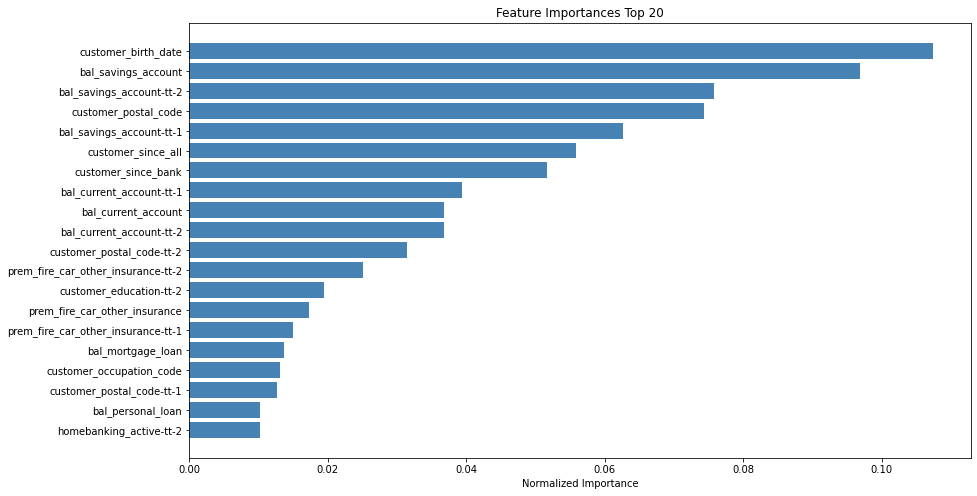

In [ ]:
fi_sorted = plot_feature_importances(fi)